In [1]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import heapq
from scipy.stats import t
import scipy.stats as stats

In [2]:
class Station:
    def __init__(self, size):
        self.size=size
        self.spaces=[0]*size
        self.happy_ships=0
        self.sad_ships=0
        self.blocked_times = []
        self.not_blocked_times = []

    
    def dock_ship(self, time):
        try:
            empty_space = self.spaces.index(0)
            self.spaces[empty_space] = 1
            self.happy_ships+=1
            self.not_blocked_times.append(time)
            return True
        except ValueError:
            self.sad_ships+=1
            self.blocked_times.append(time)
            return False
        
    def depart_ship(self):
        try:
            full_space = self.spaces.index(1)
            self.spaces[full_space]=0
            return True
        except ValueError:
            return False
        
    def print_details(self):
        print('{} happy ships'.format(self.happy_ships))
        print('{} sad ships'.format(self.sad_ships))
        print('{} total ships'.format(self.sad_ships+self.happy_ships))
        
    
    def b_formula(self):
        return(self.sad_ships/((self.sad_ships+self.happy_ships)))

In [3]:
def generate_hyperexponential(p1, l1, p2, l2):
    while True:
        u = random.random()
        if u < p1:
            return random.expovariate(l1)
        else:
            return random.expovariate(l2)

In [58]:
def run_simulation(mode):
    
    RUNS = 10000
    
    MEAN_TIME_BETWEEN_CUSTOMERS = 1
    MEAN_SERVICE_TIME = 8

    p1 = 0.8
    l1 = 0.8333
    
    p2 = 0.2
    l2 = 5.0
    
    K1 = 1.05
    K2 = 2.05

    jess_station = Station(10)
    arrival_times = []
    

    if(mode==2.1):
        arrival_times = scipy.stats.erlang.rvs(1, size = RUNS)
    elif(mode==2.2):
        arrival_times = [generate_hyperexponential(p1, l1, p2, l2) for _ in range(RUNS)]
    else:
        ## Default
        arrival_times = np.random.exponential(MEAN_TIME_BETWEEN_CUSTOMERS, size=10000)

    
    arrival_schedule = np.cumsum(arrival_times)
    
    departure_schedule = []
    num_arrivals = len(arrival_schedule)
    num_departures = 0
    num_ships_docked = 0

    for i in range(round(RUNS)):        
        arriving_ships = np.argwhere(np.floor(arrival_schedule) == i).flatten()
        num_arriving_ships = len(arriving_ships)
        
        for ship in range(num_arriving_ships):
            if jess_station.dock_ship(arrival_schedule[i]):
                
                rand_departure_time = 0                
                if(mode==3.1):
                    # Constant service time
                    rand_departure_time = 10
                elif(mode==3.2):
                    # Pareto K=1.05
                    rand_departure_time = (np.random.pareto(K1,1)+1)*(8/21)
                elif(mode==3.3):
                    # Pareto K=2.05
                    rand_departure_time = (np.random.pareto(K2,1)+1)*4.09756
                elif(mode==3.4):
                    dist = [1,2,9,10]
                    rand_departure_time = np.random.choice(dist)
                else:
                    ## Default
                    rand_departure_time = np.random.exponential(MEAN_SERVICE_TIME)
                
                heapq.heappush(departure_schedule, i + rand_departure_time)
                num_ships_docked += 1
        while departure_schedule and np.floor(departure_schedule[0]) == i:
            heapq.heappop(departure_schedule)
            jess_station.depart_ship()
            num_departures += 1
            
    return jess_station.b_formula(), jess_station.blocked_times, jess_station.not_blocked_times

In [59]:
CONFIDENCE_LEVEL = 0.95

def calculate_confidence_interval(results):   
    mean = np.mean(results)
    std = np.std(results)
    degrees_of_freedom = len(results) - 1
    critical_value = t.ppf((1 + CONFIDENCE_LEVEL) / 2, degrees_of_freedom)
    margin_of_error = critical_value * (std / np.sqrt(len(results)))
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    
    print("Mean B-Value:", mean)
    print("Standard Deviation:", std)
    print("Confidence Interval:", confidence_interval)

In [60]:
def control_variates_simulation(X,Y):
    cov = np.cov(X,Y)
    meanY = np.mean(Y)
    c = -cov[0,1]/cov[1,1]

    value_array = X+c*(Y-meanY)

    value_mean = np.mean(value_array) 
    value_std = np.std(value_array)
    return value_array

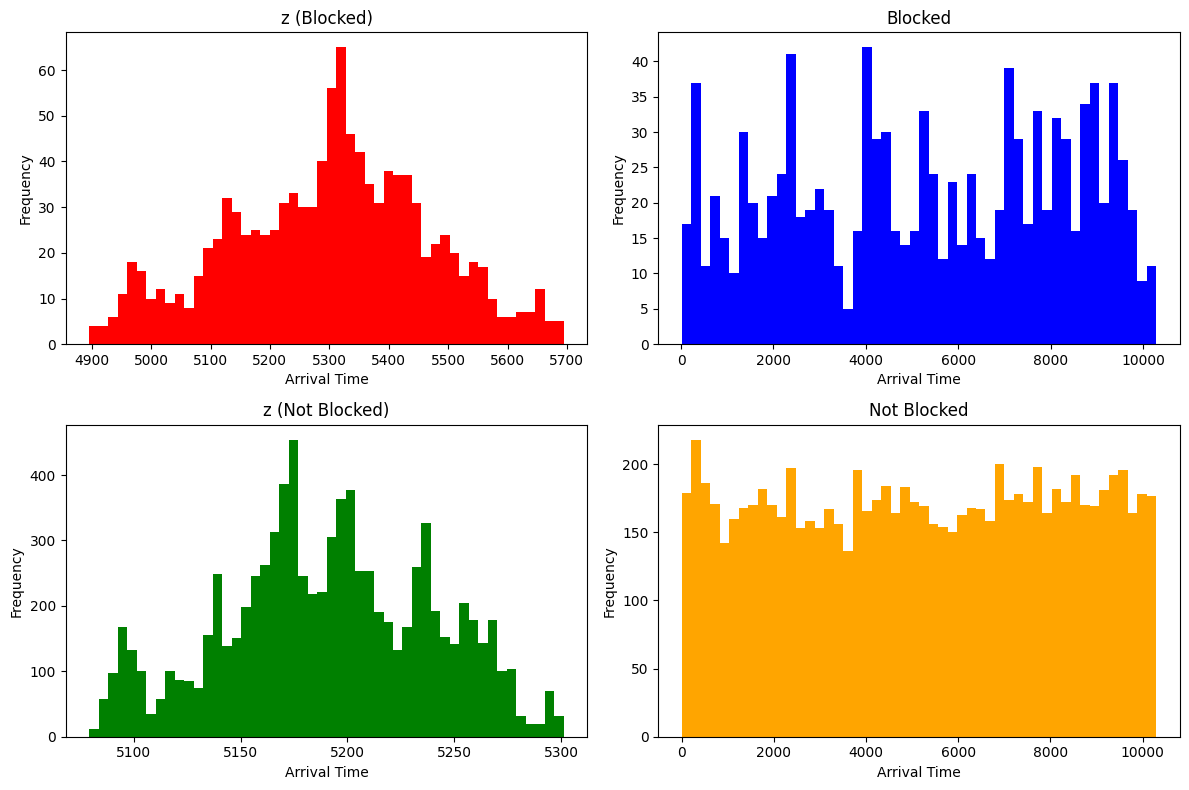

Blocked variance: 8657569.949880637
Blocked using control variates simulation variance: 28507.39075363869

Not Blocked variance: 9052090.390062999
Not Blocked using control variates simulation variance: 2378.4381908363944


In [97]:
_,blocked,notblocked = run_simulation(1)

z1 = control_variates_simulation(blocked,np.cumsum([1]*len(blocked)))
z2 = control_variates_simulation(notblocked,np.cumsum([1]*len(notblocked)))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(z1, 50, color='red')
axs[0, 0].set_title('z (Blocked)')
axs[0, 0].set_xlabel('Arrival Time')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(blocked, 50, color='blue')
axs[0, 1].set_title('Blocked')
axs[0, 1].set_xlabel('Arrival Time')
axs[0, 1].set_ylabel('Frequency')

axs[1, 0].hist(z2, 50, color='green')
axs[1, 0].set_title('z (Not Blocked)')
axs[1, 0].set_xlabel('Arrival Time')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(notblocked, 50, color='orange')
axs[1, 1].set_title('Not Blocked')
axs[1, 1].set_xlabel('Arrival Time')
axs[1, 1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

print("Blocked variance:", np.var(blocked))
print("Blocked using control variates simulation variance:", np.var(z1))
print()
print("Not Blocked variance:", np.var(notblocked))
print("Not Blocked using control variates simulation variance:", np.var(z2))